# Model Analysis and Interpretation

This notebook performs:
1.  **SHAP Value Analysis**: To understand feature importance and how features influence predictions.
2.  **Outlier & High Residual Analysis**: Using SHAP to investigate instances where the model's predictions deviate significantly from actual values.
3.  **Counterfactual Exploration (Conceptual)**: Manually exploring how changing influential features impacts predictions for specific instances.
4.  **Hyperparameter Quality Visualization**: Using Optuna's visualization tools to analyze hyperparameter tuning results.

--- 
## 1. Setup and Imports

Import necessary libraries and modules from your project.

In [1]:
import json
import logging
import os
import sys
import warnings

import lightgbm as lgb
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import optuna
import pandas as pd
import plotly
import shap 
import xgboost as xgb
from sklearn.model_selection import KFold

notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, os.pardir))

if project_root not in sys.path:
    sys.path.insert(0, project_root) # Insert at the beginning to prioritize local modules
    print(f"Added '{project_root}' to sys.path for module imports.")
else:
    print(f"'{project_root}' already in sys.path.")
# ----------------------------------------------------------------


from config import load_config
from preprocessor import create_data_transformer_pipeline
from split_data import get_train_test_data, get_train_test_img



# Configure logging and warnings
logging.basicConfig(
    level=logging.INFO,
    handlers=[logging.StreamHandler()],
    format="%(asctime)s - %(levelname)s - %(message)s",
)
logging.getLogger("lightgbm").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")
pd.set_option("display.float_format", "{:.4f}".format)
shap.initjs()

/Users/sergiocarcamo/Dev/thesis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Added '/Users/sergiocarcamo/Dev/thesis' to sys.path for module imports.


--- 
## 2. Configuration and MLflow Setup

Load configurations and define MLflow experiment details.

**ACTION REQUIRED**:
- `SELECTED_FEATURES_FILENAME_FOR_ANALYSIS`: Set this to the name of the feature set JSON file (without .json extension) for the model you want to analyze (e.g., `"rfecv_all_nfeat_44_pca_scaled_count"`).
- `MODEL_NAME_FOR_ANALYSIS`: Set this to the model type you want to analyze (e.g., `"LightGBM"`, `"XGBoost"`).
- `MLFLOW_RUN_ID_FOR_ANALYSIS` (Optional): If you know the specific MLflow Run ID for the "BEST" model run, set it here. Otherwise, the notebook will try to find the best run based on `MODEL_NAME_FOR_ANALYSIS` and `SELECTED_FEATURES_FILENAME_FOR_ANALYSIS`.

In [2]:
config_values = load_config() # Assumes config.yaml is in ./config/

TARGET_VARIABLE = config_values.get("TARGET_VARIABLE", "price")
RANDOM_STATE = config_values.get("RANDOM_STATE", 42)
SELECTED_FEATURES_DIR = config_values.get("SELECTED_FEATURES_DIR", "feature_sets")
MLFLOW_TRACKING_URI = mlflow.get_tracking_uri() # Or set your MLflow tracking URI if not local

# === ACTION REQUIRED: Specify the feature set and model to analyze ===
SELECTED_FEATURES_FILENAME_FOR_ANALYSIS = "rfecv_all_nfeat_44_pca_scaled_count" # Example
MODEL_NAME_FOR_ANALYSIS = "LightGBM" # Example: "LightGBM", "XGBoost"
MLFLOW_RUN_ID_FOR_ANALYSIS = None # Optional: "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"
# =====================================================================



# Derived configurations
selected_features_path_for_analysis = os.path.join(
    "..", SELECTED_FEATURES_DIR, f"{SELECTED_FEATURES_FILENAME_FOR_ANALYSIS}.json"
)

# MLflow experiment name (must match the one used in train.py)
feature_set_identifier = SELECTED_FEATURES_FILENAME_FOR_ANALYSIS.replace(".json", "")
MLFLOW_EXPERIMENT_NAME = (
    f"Flat price predictor - {TARGET_VARIABLE} - {feature_set_identifier}"
)

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)

logging.info(f"Using MLflow Tracking URI: {MLFLOW_TRACKING_URI}")
logging.info(f"Using MLflow Experiment: '{MLFLOW_EXPERIMENT_NAME}'")
logging.info(f"Analyzing model: {MODEL_NAME_FOR_ANALYSIS} with feature set: {SELECTED_FEATURES_FILENAME_FOR_ANALYSIS}")

2025-06-03 11:55:58,431 - INFO - Using MLflow Tracking URI: file:///Users/sergiocarcamo/Dev/thesis/notebooks/mlruns
2025-06-03 11:55:58,432 - INFO - Using MLflow Experiment: 'Flat price predictor - price - rfecv_all_nfeat_44_pca_scaled_count'
2025-06-03 11:55:58,432 - INFO - Analyzing model: LightGBM with feature set: rfecv_all_nfeat_44_pca_scaled_count


--- 
## 3. Load Data and Feature Selection Metadata

Load the test data and metadata from the selected feature set.

In [3]:
# Load feature selection metadata
try:
    with open(selected_features_path_for_analysis, "r") as f:
        feature_data = json.load(f)
        selected_feature_names_from_file = feature_data.get("selected_features", [])
        feature_selection_metadata = feature_data.get("metadata", {})
    if not selected_feature_names_from_file:
        raise ValueError("No 'selected_features' found in JSON.")
    if not feature_selection_metadata:
        logging.warning("No 'metadata' found in feature selection JSON. Using global defaults.")
    else:
        logging.info(f"Loaded feature selection metadata: {feature_selection_metadata}")
except Exception as e:
    logging.error(f"Error loading feature selection file {selected_features_path_for_analysis}: {e}")
    raise

# Override global configurations based on metadata from the feature selection file
APPLY_SCALE_TRANSFORM = feature_selection_metadata.get(
    "apply_scale_transform", config_values.get("APPLY_SCALE_TRANSFORM")
)
APPLY_PCA_IMG_TRANSFORM = feature_selection_metadata.get(
    "apply_pca_img_transform", config_values.get("APPLY_PCA_IMG_TRANSFORM")
)
N_PCA_COMPONENTS = feature_selection_metadata.get(
    "n_pca_components", config_values.get("N_PCA_COMPONENTS")
)
# Ensure RANDOM_STATE is consistent if it was part of metadata
current_random_state = feature_selection_metadata.get("random_state", RANDOM_STATE)
if current_random_state != RANDOM_STATE:
    logging.info(f"RANDOM_STATE overridden by metadata: {current_random_state}")
    RANDOM_STATE = current_random_state
    np.random.seed(RANDOM_STATE)

logging.info(f"Effective APPLY_SCALE_TRANSFORM: {APPLY_SCALE_TRANSFORM}")
logging.info(f"Effective APPLY_PCA_IMG_TRANSFORM: {APPLY_PCA_IMG_TRANSFORM}")
logging.info(f"Effective N_PCA_COMPONENTS: {N_PCA_COMPONENTS}")



# Load data
X_train_full_raw, X_test_full_raw, Y_train_raw, Y_test_raw = get_train_test_data(include_count=feature_selection_metadata.get("include_count", True))
img_train_raw, img_test_raw = get_train_test_img()

# Keep a small sample for faster SHAP computation if needed, otherwise use full X_test_full_raw
# X_test_sample = X_test_full_raw.sample(n=1000, random_state=RANDOM_STATE) if len(X_test_full_raw) > 1000 else X_test_full_raw
X_test_sample = X_test_full_raw # Using full test set for this example

# Log-transform target variable (as done in training)
Y_train_log_transformed = np.log(Y_train_raw[TARGET_VARIABLE])
Y_test_log_transformed = np.log(Y_test_raw[TARGET_VARIABLE])



logging.info(f"X_test_sample shape: {X_test_sample.shape}")
logging.info(f"Y_test_log_transformed shape: {Y_test_log_transformed.shape}")

# Define original column types for the preprocessor (similar to train.py)
district_col_name = "district"
outlier_col_name = "outlier"

original_img_cols = img_train_raw.columns.tolist()
original_numeric_cols = X_train_full_raw.select_dtypes(include=np.number).columns.tolist()
original_numeric_cols = [
    col for col in original_numeric_cols
    if col != TARGET_VARIABLE and col != outlier_col_name and col not in original_img_cols
]
original_categorical_cols = X_train_full_raw.select_dtypes(include=["object", "category"]).columns.tolist()
original_categorical_cols = [col for col in original_categorical_cols if col != district_col_name]

2025-06-03 11:55:58,439 - INFO - Loaded feature selection metadata: {'method': 'rfecv', 'feature_subset_used': 'all', 'n_features_selected': 44, 'apply_pca_img_transform': True, 'apply_scale_transform': True, 'include_count': True, 'n_estimators': 100, 'random_state': 42, 'rfe_step_size': 0.1, 'n_pca_components': 0.8}
2025-06-03 11:55:58,440 - INFO - Effective APPLY_SCALE_TRANSFORM: True
2025-06-03 11:55:58,440 - INFO - Effective APPLY_PCA_IMG_TRANSFORM: True
2025-06-03 11:55:58,441 - INFO - Effective N_PCA_COMPONENTS: 0.8
2025-06-03 11:56:11,532 - INFO - X_test_sample shape: (9360, 696)
2025-06-03 11:56:11,546 - INFO - Y_test_log_transformed shape: (9360,)


In [4]:
mlflow.set_tracking_uri("file:///Users/sergiocarcamo/Dev/thesis/mlruns")

mlflow.search_runs(
    search_all_experiments=True, 
    filter_string="tags.\"mlflow.runName\" = 'LightGBM_rfecv_all_nfeat_44_pca_scaled_count_BEST' AND tags.run_type = 'best_run'",
    order_by=["metrics.cv_mape ASC"],     

)
# LightGBM_rfecv_all_nfeat_44_pca_scaled_count_BEST

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.train_final_r2,metrics.cv_mape,metrics.test_final_r2,metrics.best_optuna_cv_mape,...,params.optuna_direction,tags.mlflow.log-model.history,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.parentRunId,tags.mlflow.runName,tags.feature_set,tags.mlflow.source.git.commit,tags.run_type
0,dcf5e78fba984131b7d0655b681faa72,856005883594059767,FINISHED,file:///Users/sergiocarcamo/Dev/thesis/mlruns/...,2025-05-28 23:53:43.884000+00:00,2025-05-28 23:53:47.058000+00:00,0.9981,0.0591,0.9371,0.0591,...,minimize,"[{""run_id"": ""dcf5e78fba984131b7d0655b681faa72""...",sergiocarcamo,train.py,LOCAL,43fcba521dad4b2bb71a81746114fc35,LightGBM_rfecv_all_nfeat_44_pca_scaled_count_BEST,rfecv_all_nfeat_44_pca_scaled_count,7489220decb296d28fcd41d301f2da788ac8a807,best_run


--- 
## 4. Load Trained Model and Preprocessor from MLflow

We need to find the "BEST" run for the specified model and feature set, then load the model and reconstruct the preprocessor.

In [8]:
from xgboost import XGBRegressor

if 'MLFLOW_RUN_ID_FOR_ANALYSIS' not in locals() or MLFLOW_RUN_ID_FOR_ANALYSIS is None:
    try:
        experiment = mlflow.get_experiment_by_name(MLFLOW_EXPERIMENT_NAME)
        if experiment is None:
            raise ValueError(f"Experiment '{MLFLOW_EXPERIMENT_NAME}' not found.")
        
        # Query for runs tagged as "best_run" for the specified model and feature set
        # The run name in train.py is like: f"{model_name}_{SELECTED_FEATURES_FILENAME}_BEST"
        target_run_name = f"{MODEL_NAME_FOR_ANALYSIS}_{SELECTED_FEATURES_FILENAME_FOR_ANALYSIS}_BEST"
        
        print(MLFLOW_EXPERIMENT_NAME, experiment.experiment_id, target_run_name)

        best_runs_df = mlflow.search_runs(
            search_all_experiments=True, 
            experiment_ids=[experiment.experiment_id],
            filter_string=f"tags.mlflow.runName = '{target_run_name}' AND tags.run_type = 'best_run'",
            order_by=["metrics.test_final_mape ASC"], # Assuming lower MAPE is better
            max_results=1
        )

        if best_runs_df.empty:
            raise ValueError(f"No 'best_run' found for {MODEL_NAME_FOR_ANALYSIS} with feature set {SELECTED_FEATURES_FILENAME_FOR_ANALYSIS} and name {target_run_name}.")
        
        MLFLOW_RUN_ID_FOR_ANALYSIS = best_runs_df.iloc[0]["run_id"]
        logging.info(f"Found best run ID: {MLFLOW_RUN_ID_FOR_ANALYSIS} with name '{target_run_name}'")
    except Exception as e:
        logging.error(f"Could not automatically find the best run: {e}")
        logging.error("Please set MLFLOW_RUN_ID_FOR_ANALYSIS manually.")
        raise

# Load the model
# The model artifact path in train.py is like f"{MODEL_NAME_FOR_ANALYSIS}_model" or f"{MODEL_NAME_FOR_ANALYSIS}_pipeline"
model_artifact_path_sklearn = f"runs:/{MLFLOW_RUN_ID_FOR_ANALYSIS}/{MODEL_NAME_FOR_ANALYSIS}_pipeline"
model_artifact_path_native = f"runs:/{MLFLOW_RUN_ID_FOR_ANALYSIS}/{MODEL_NAME_FOR_ANALYSIS}_model"

loaded_model = None
actual_model = None # Initialize actual_model

try:
    if MODEL_NAME_FOR_ANALYSIS in ["LightGBM", "XGBoost", "XGBoostQuantile"]:
        if MODEL_NAME_FOR_ANALYSIS == "LightGBM":
            try:
                logging.info(f"Trying to load LightGBM native model from {model_artifact_path_native}")
                actual_model = mlflow.lightgbm.load_model(model_artifact_path_native)
                logging.info(f"Successfully loaded native LightGBM model: {type(actual_model)}")
            except Exception as e:
                logging.warning(f"Failed to load native LightGBM model directly: {e}")
                logging.info(f"Falling back to pyfunc.load_model and attempting extraction...")
                loaded_model = mlflow.pyfunc.load_model(model_artifact_path_native)
                actual_model = loaded_model # Keep as PyFunc for now

        elif MODEL_NAME_FOR_ANALYSIS in ["XGBoost", "XGBoostQuantile"]:
            try:
                logging.info(f"Trying to load XGBoost native model from {model_artifact_path_native}")
                actual_model = mlflow.xgboost.load_model(model_artifact_path_native)
                logging.info(f"Successfully loaded native XGBoost model: {type(actual_model)}")
            except Exception as e:
                logging.warning(f"Failed to load native XGBoost model directly: {e}")
                logging.info(f"Falling back to pyfunc.load_model and attempting extraction...")
                loaded_model = mlflow.pyfunc.load_model(model_artifact_path_native)
                actual_model = loaded_model # Keep as PyFunc for now

        # Define the types to check against for XGBoost, including the Booster (native) and scikit-learn wrappers
        xgboost_model_types = (xgb.Booster, XGBRegressor)
        direct_tree_model_types = (lgb.Booster, lgb.LGBMRegressor) + xgboost_model_types

        # If after trying native loads, actual_model is still None or not the native type,
        # it means the model might have been logged only as a PyFunc without a specific
        # native flavor, or a pipeline with a PyFunc wrapper.
        if actual_model is None or not isinstance(actual_model, direct_tree_model_types):
            logging.warning(f"Native model for {MODEL_NAME_FOR_ANALYSIS} not directly loaded. SHAP might be slower or require KernelExplainer.")
            if loaded_model is None:
                 loaded_model = mlflow.pyfunc.load_model(model_artifact_path_native)
            actual_model = loaded_model # Use the PyFunc model for SHAP

        # --- Your existing fallback for SKLearn pipelines if native doesn't work ---
        # This part handles cases where the model might have been saved as a generic
        # sklearn model, even for LightGBM/XGBoost if they were wrapped in sklearn pipelines.
        if actual_model is None or not isinstance(actual_model, (lgb.Booster,) + xgboost_model_types):
             try:
                 logging.info(f"Attempting to load {MODEL_NAME_FOR_ANALYSIS} as sklearn model/pipeline from {model_artifact_path_sklearn}")
                 sklearn_pipeline_model = mlflow.sklearn.load_model(model_artifact_path_sklearn)
                 if hasattr(sklearn_pipeline_model, 'named_steps') and 'model' in sklearn_pipeline_model.named_steps:
                     actual_model = sklearn_pipeline_model.named_steps['model']
                     logging.info(f"Successfully loaded model step from sklearn pipeline: {type(actual_model)}")
                 else:
                     actual_model = sklearn_pipeline_model # It might be the model itself
                     logging.info(f"Successfully loaded sklearn model/pipeline: {type(actual_model)}")
             except Exception as e_sklearn:
                 logging.error(f"Failed to load as sklearn model/pipeline from {model_artifact_path_sklearn}: {e_sklearn}")
                 if actual_model is None: # Only raise if no model was loaded at all
                     raise ValueError(f"No model could be loaded for {MODEL_NAME_FOR_ANALYSIS}")

    else: # For RandomForest, DecisionTree, Lasso, Ridge, ElasticNet (logged as sklearn pipelines)
        logging.info(f"Loading {MODEL_NAME_FOR_ANALYSIS} as sklearn pipeline from {model_artifact_path_sklearn}")
        sklearn_pipeline_model = mlflow.sklearn.load_model(model_artifact_path_sklearn)
        if hasattr(sklearn_pipeline_model, 'named_steps') and 'model' in sklearn_pipeline_model.named_steps:
            actual_model = sklearn_pipeline_model.named_steps['model']
            logging.info(f"Successfully extracted model from sklearn pipeline: {type(actual_model)}")
        else:
            actual_model = sklearn_pipeline_model
            logging.info(f"Successfully loaded sklearn model directly: {type(actual_model)}")

    if actual_model is None:
        raise ValueError("Model was not successfully loaded into 'actual_model'.")

    logging.info(f"Successfully loaded model: {MODEL_NAME_FOR_ANALYSIS} (type: {type(actual_model)}) from run ID: {MLFLOW_RUN_ID_FOR_ANALYSIS}")

except Exception as e:
    logging.error(f"Error loading model from MLflow run {MLFLOW_RUN_ID_FOR_ANALYSIS}: {e}")
    logging.error(f"Tried paths: {model_artifact_path_native} (native) and {model_artifact_path_sklearn} (sklearn pipeline)")
    raise

2025-06-03 13:04:20,400 - INFO - Trying to load LightGBM native model from runs:/dcf5e78fba984131b7d0655b681faa72/LightGBM_model
2025-06-03 13:04:20,532 - INFO - Successfully loaded native LightGBM model: <class 'lightgbm.sklearn.LGBMRegressor'>
2025-06-03 13:04:20,532 - INFO - Attempting to load LightGBM as sklearn model/pipeline from runs:/dcf5e78fba984131b7d0655b681faa72/LightGBM_pipeline
2025-06-03 13:04:20,537 - ERROR - Failed to load as sklearn model/pipeline from runs:/dcf5e78fba984131b7d0655b681faa72/LightGBM_pipeline: No such file or directory: '/Users/sergiocarcamo/Dev/thesis/mlruns/856005883594059767/dcf5e78fba984131b7d0655b681faa72/artifacts/LightGBM_pipeline'
2025-06-03 13:04:20,537 - INFO - Successfully loaded model: LightGBM (type: <class 'lightgbm.sklearn.LGBMRegressor'>) from run ID: dcf5e78fba984131b7d0655b681faa72


In [9]:
# Reconstruct and fit the data transformer
# This must exactly match the preprocessing used for the loaded model
data_transformer = create_data_transformer_pipeline(
    numeric_cols=original_numeric_cols,
    categorical_cols=original_categorical_cols,
    img_feature_cols=original_img_cols,
    district_group_col=district_col_name,
    outlier_indicator_col=outlier_col_name,
    apply_scaling_and_transform=APPLY_SCALE_TRANSFORM,
    apply_pca=APPLY_PCA_IMG_TRANSFORM,
    n_pca_components=N_PCA_COMPONENTS
)

# Fit the transformer on the FULL training data (as done before training the final model in train.py)
logging.info("Fitting data_transformer on X_train_full_raw...")
data_transformer.fit(X_train_full_raw.copy(), Y_train_log_transformed)
logging.info("Data_transformer fitted.")

# Transform the test sample
X_test_processed_np = data_transformer.transform(X_test_sample.copy())

# Get feature names after transformation
try:
    processed_feature_names = data_transformer.get_feature_names_out()
    X_test_processed_df = pd.DataFrame(
        X_test_processed_np,
        columns=processed_feature_names,
        index=X_test_sample.index
    )
    logging.info(f"X_test_processed_df shape: {X_test_processed_df.shape}")
except Exception as e:
    logging.error(f"Error getting feature names from transformer: {e}. SHAP plots might lack feature names.")
    # Fallback if names can't be retrieved, SHAP will use integer indices
    X_test_processed_df = pd.DataFrame(X_test_processed_np, index=X_test_sample.index)


# Select the features that the model was trained on
# These names come from the `selected_features_names_from_file` loaded earlier,
# which are the names *after* transformation.
final_selected_feature_names_for_model = [
    name for name in selected_feature_names_from_file if name in X_test_processed_df.columns
]

if len(final_selected_feature_names_for_model) != len(selected_feature_names_from_file):
    missing_in_test_processed = set(selected_feature_names_from_file) - set(final_selected_feature_names_for_model)
    logging.warning(f"Some selected features from file were not found in the processed test data columns. Missing: {missing_in_test_processed}")
    logging.warning(f"Using {len(final_selected_feature_names_for_model)} available features.")


if not final_selected_feature_names_for_model:
    raise ValueError("No selected features are present in the processed test data. Check feature names and preprocessing consistency.")

X_test_selected_final = X_test_processed_df[final_selected_feature_names_for_model]
logging.info(f"X_test_selected_final shape for SHAP: {X_test_selected_final.shape}")

2025-06-03 13:04:23,508 - INFO - Fitting data_transformer on X_train_full_raw...
2025-06-03 13:04:33,743 - INFO - Data_transformer fitted.
2025-06-03 13:04:34,166 - INFO - X_test_processed_df shape: (9360, 360)
2025-06-03 13:04:34,168 - INFO - X_test_selected_final shape for SHAP: (9360, 44)


--- 
## 5. SHAP Analysis

Calculate and visualize SHAP values to understand feature contributions.

In [10]:
# Initialize SHAP Explainer
# For tree-based models like LightGBM, XGBoost, RandomForest

import logging


logging.getLogger('shap').setLevel(logging.WARNING)

# Initialize sklearn_pipeline_model to None
sklearn_pipeline_model = None # This line was added in the previous fix

# Determine if actual_model is a native LightGBM/XGBoost model or a PyFuncModel/pipeline
is_native_tree_model = isinstance(actual_model, (lgb.Booster, lgb.LGBMRegressor,
                                                 xgb.Booster, xgb.XGBRegressor,))

# Define a wrapper prediction function to ensure DataFrame input with correct columns
# This is crucial for MLflow PyFuncModels which enforce schema.
def wrapped_predict_fn(data_input, model_to_predict, feature_columns):
    """
    Wraps the model's predict function to ensure input is a pandas DataFrame
    with the correct column names, as expected by MLflow PyFuncModels.
    """
    if isinstance(data_input, np.ndarray):
        # Convert numpy array to DataFrame, preserving column names
        data_input_df = pd.DataFrame(data_input, columns=feature_columns)
    elif isinstance(data_input, pd.DataFrame):
        # Ensure column order matches if it's already a DataFrame
        data_input_df = data_input[feature_columns]
    else:
        raise TypeError(f"Unexpected input type for wrapped_predict_fn: {type(data_input)}")

    return model_to_predict.predict(data_input_df)


if is_native_tree_model:
    try:
        # Check if actual_model is the base estimator and not a pipeline
        if hasattr(actual_model, 'predict_proba') or hasattr(actual_model, 'predict'): # Basic check for model-like object
             explainer = shap.TreeExplainer(actual_model, data=X_test_selected_final) # Provide data for background
             logging.info(f"Using shap.TreeExplainer for native {MODEL_NAME_FOR_ANALYSIS} model.")
        else:
            raise TypeError(f"actual_model is of type {type(actual_model)}, not a base estimator suitable for TreeExplainer. It might be a pipeline.")
    except Exception as tree_explainer_ex:
        logging.warning(f"Could not initialize TreeExplainer directly for {type(actual_model)} (Error: {tree_explainer_ex}). Falling back to KernelExplainer, which will be slower.")
        # Fallback to KernelExplainer if TreeExplainer fails

        # Determine the model object whose predict method will be called
        model_object_for_predict = None
        if sklearn_pipeline_model is not None:
            model_object_for_predict = sklearn_pipeline_model
        else:
            model_object_for_predict = actual_model

        if model_object_for_predict is None or not hasattr(model_object_for_predict, 'predict'):
            logging.error("Cannot determine suitable model object or predict function for KernelExplainer.")
            raise ValueError("No suitable predict function found for SHAP KernelExplainer.")

        # Create the actual predict function for SHAP KernelExplainer
        # This function will always receive a DataFrame with correct column names/order
        # because we are wrapping it.
        predict_fn_for_shap = lambda x: wrapped_predict_fn(x, model_object_for_predict, final_selected_feature_names_for_model)

        X_train_processed_shap_bg_np = data_transformer.transform(X_train_full_raw.sample(min(100, len(X_train_full_raw)), random_state=RANDOM_STATE).copy())
        X_train_processed_shap_bg_df = pd.DataFrame(X_train_processed_shap_bg_np, columns=processed_feature_names)[final_selected_feature_names_for_model]

        explainer = shap.KernelExplainer(predict_fn_for_shap, X_train_processed_shap_bg_df)
        logging.info(f"Using shap.KernelExplainer for {MODEL_NAME_FOR_ANALYSIS}.")
else: # For other models (e.g., linear models might be part of a pipeline) or if the model loaded as PyFunc
    logging.info(f"Attempting KernelExplainer for {MODEL_NAME_FOR_ANALYSIS} as it's not a direct native tree model or was loaded as PyFunc.")
    # Summarize the background data for KernelExplainer
    X_train_sample_raw = X_train_full_raw.sample(min(100, len(X_train_full_raw)), random_state=RANDOM_STATE).copy()
    X_train_bg_processed_np = data_transformer.transform(X_train_sample_raw)
    X_train_bg_processed_df = pd.DataFrame(X_train_bg_processed_np, columns=processed_feature_names, index=X_train_sample_raw.index)
    X_train_bg_selected_final = X_train_bg_processed_df[final_selected_feature_names_for_model]

    # Determine the model object whose predict method will be called
    model_object_for_predict = None
    if sklearn_pipeline_model is not None:
        model_object_for_predict = sklearn_pipeline_model
    else:
        model_object_for_predict = actual_model

    if model_object_for_predict is None or not hasattr(model_object_for_predict, 'predict'):
        logging.error("Cannot determine suitable model object or predict function for KernelExplainer.")
        raise ValueError("No suitable predict function found for SHAP KernelExplainer.")

    # Create the actual predict function for SHAP KernelExplainer
    predict_fn_for_shap = lambda x: wrapped_predict_fn(x, model_object_for_predict, final_selected_feature_names_for_model)

    explainer = shap.KernelExplainer(predict_fn_for_shap, X_train_bg_selected_final)
    logging.info(f"Using shap.KernelExplainer for {MODEL_NAME_FOR_ANALYSIS}.")


# Calculate SHAP values
# Using a smaller sample for X_test_selected_final if it's too large for KernelExplainer
# Ensure X_test_selected_final is a DataFrame for the predict_fn_for_shap
shap_values_test = explainer.shap_values(X_test_selected_final)
logging.info("SHAP values calculated.")

# If shap_values is a list (e.g. for multi-output models), take the first element for regression
if isinstance(shap_values_test, list):
    shap_values_test = shap_values_test[0]

2025-06-03 13:06:25,262 - INFO - Using shap.TreeExplainer for native LightGBM model.
100%|===================| 9352/9360 [06:51<00:00]        2025-06-03 13:13:16,928 - INFO - SHAP values calculated.


### Global Feature Importance (Bar Plot)

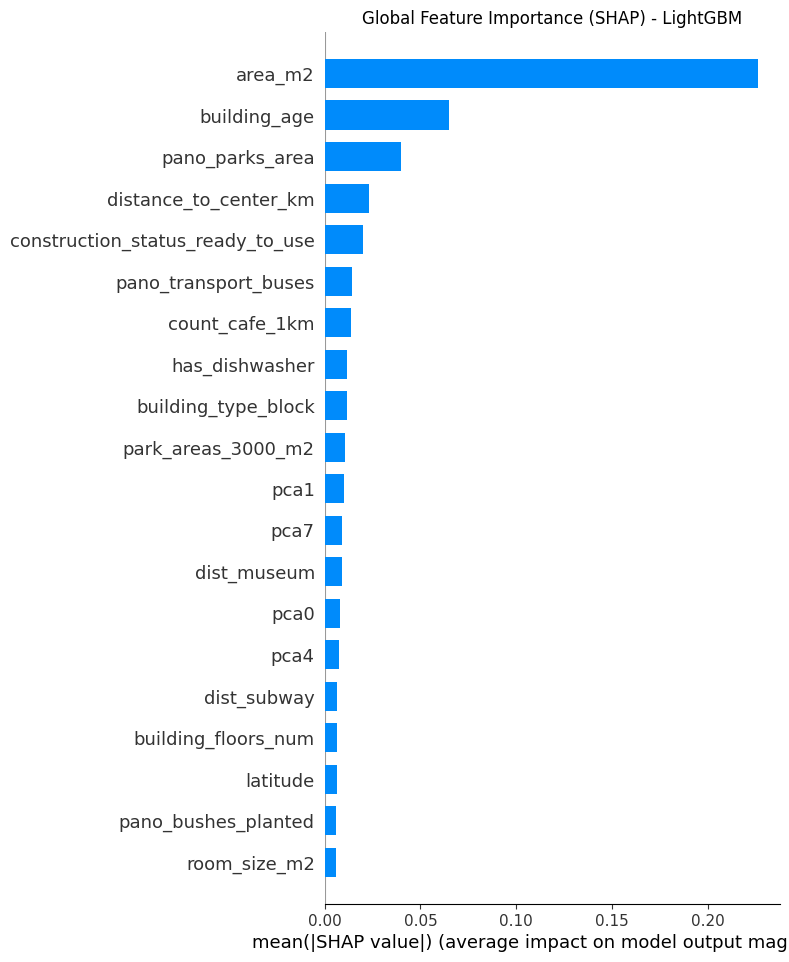

In [11]:
shap.summary_plot(shap_values_test, X_test_selected_final, plot_type="bar", show=False)
plt.title(f"Global Feature Importance (SHAP) - {MODEL_NAME_FOR_ANALYSIS}")
plt.show()

### SHAP Summary Plot (Beeswarm)
Shows feature importance and impact. Each dot is a data point. Color indicates feature value (red=high, blue=low). X-axis is SHAP value.

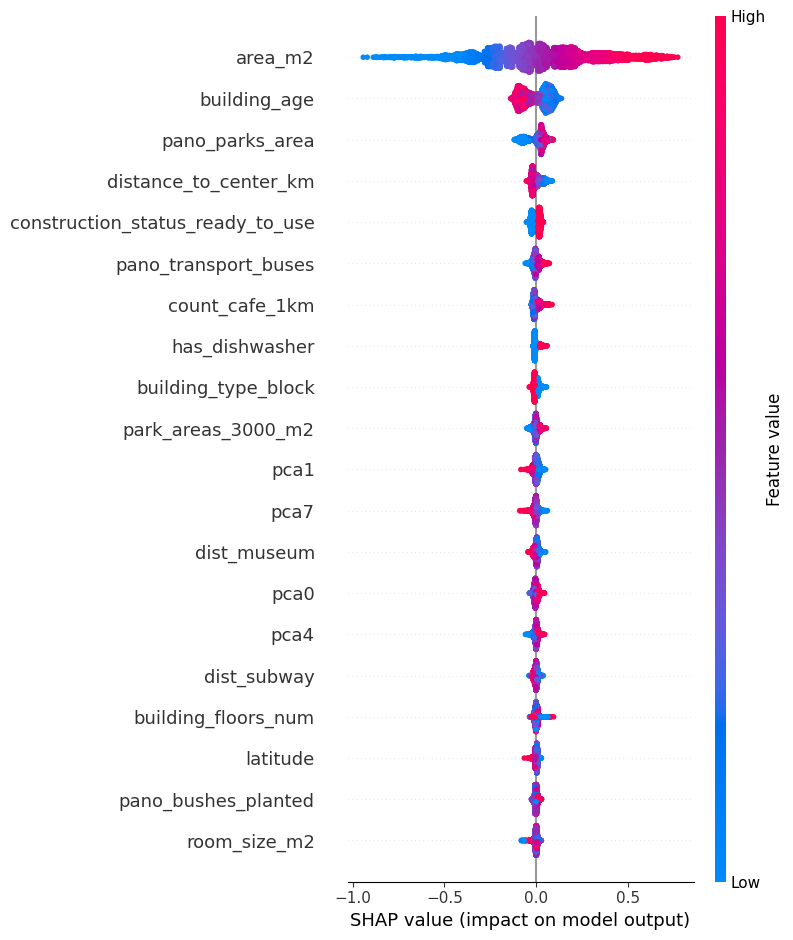

In [12]:
shap.summary_plot(shap_values_test, X_test_selected_final, show=False)
# plt.title(f"SHAP Summary Plot - {MODEL_NAME_FOR_ANALYSIS}") # Title might not be directly settable on this plot
plt.show()

### SHAP Dependence Plots
Shows how a single feature's value affects its SHAP value (and thus the prediction), optionally colored by an interaction feature.
**ACTION REQUIRED**: Update `features_to_plot` with relevant feature names from `final_selected_feature_names_for_model`.

2025-06-03 13:26:53,129 - INFO - Generating dependence plots for features: ['area_m2', 'building_age', 'pano_parks_area', 'distance_to_center_km', 'construction_status_ready_to_use']


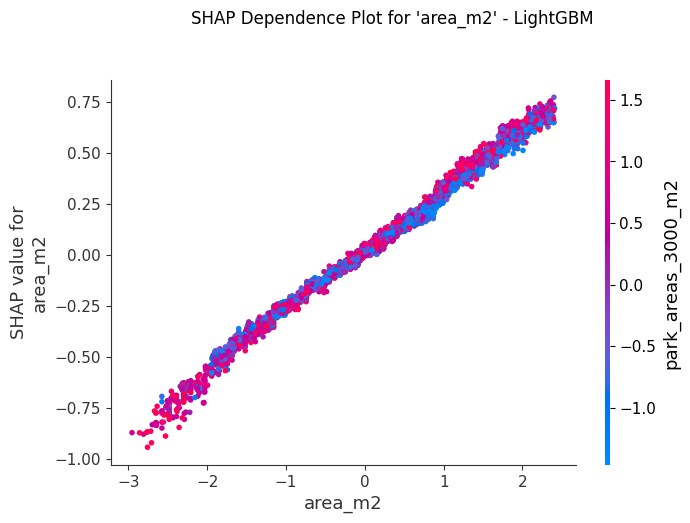

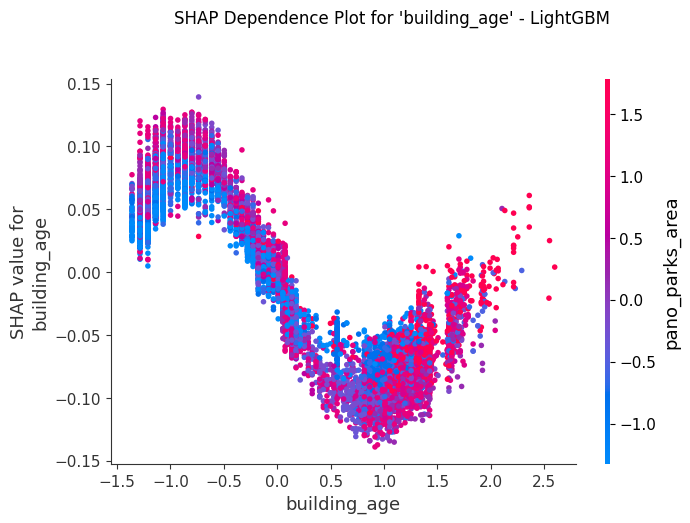

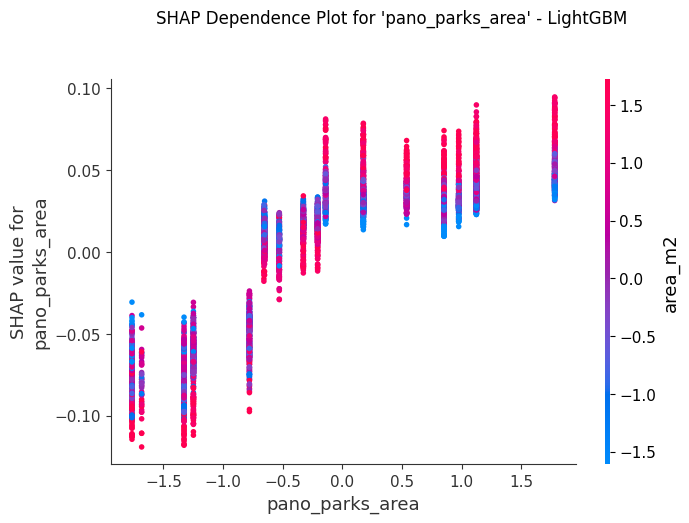

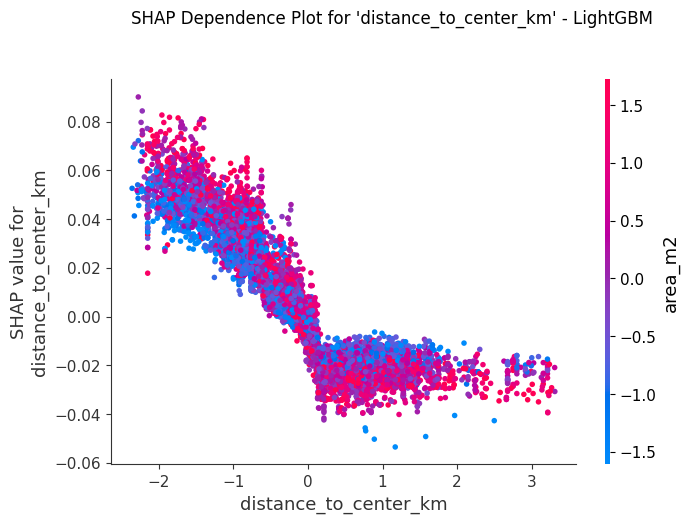

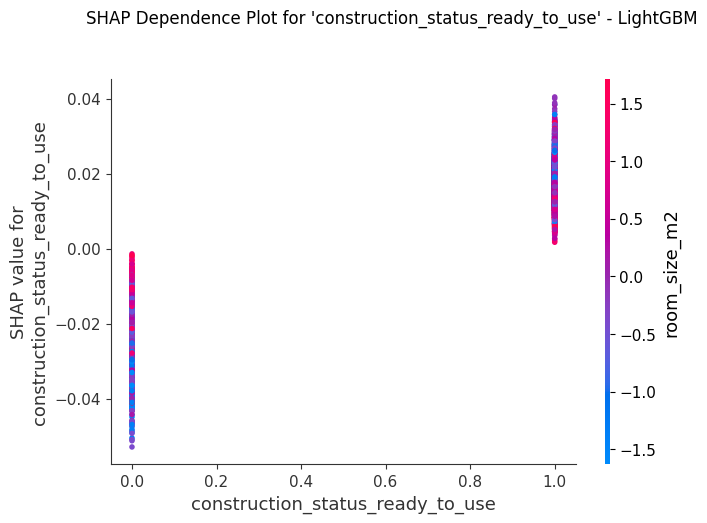

In [13]:
if len(final_selected_feature_names_for_model) > 0:
    # Plot for top few features or specific features of interest
    num_dependence_plots = min(5, len(final_selected_feature_names_for_model))
    
    # To get top features by mean absolute SHAP value:
    mean_abs_shap = np.abs(shap_values_test).mean(0)
    if isinstance(X_test_selected_final, pd.DataFrame):
        feature_names_for_plot = X_test_selected_final.columns
    else: # if it's a numpy array (less ideal)
        feature_names_for_plot = [f"feature_{i}" for i in range(X_test_selected_final.shape[1])]

    top_feature_indices = np.argsort(mean_abs_shap)[::-1][:num_dependence_plots]
    features_to_plot = [feature_names_for_plot[i] for i in top_feature_indices]
    
    logging.info(f"Generating dependence plots for features: {features_to_plot}")

    for feature_name in features_to_plot:
        try:
            shap.dependence_plot(
                feature_name,
                shap_values_test,
                X_test_selected_final,
                interaction_index="auto", # Automatically picks an interaction feature
                show=False
            )
            plt.suptitle(f"SHAP Dependence Plot for '{feature_name}' - {MODEL_NAME_FOR_ANALYSIS}", y=1.02)
            plt.show()
        except Exception as e:
            logging.warning(f"Could not generate dependence plot for {feature_name}: {e}")
else:
    logging.warning("No features available to generate dependence plots.")

--- 
## 6. Outlier & High Residual Analysis with SHAP

Investigate instances where the model's predictions are significantly off.

In [14]:
# Make predictions on the selected test set (log scale)
# Ensure using the 'actual_model' if it's the base estimator, or the full pipeline if KernelExplainer was used on it.
if 'sklearn_pipeline_model' in locals() and (MODEL_NAME_FOR_ANALYSIS not in ["LightGBM", "XGBoost", "XGBoostQuantile"] or not hasattr(actual_model, 'predict')): # If it's a pipeline
    Y_predict_log_test = sklearn_pipeline_model.predict(X_test_selected_final)
    logging.info("Predictions made using the sklearn_pipeline_model for residuals.")
else: # If actual_model is the base estimator
    Y_predict_log_test = actual_model.predict(X_test_selected_final)
    logging.info("Predictions made using the actual_model (base estimator) for residuals.")


# Inverse transform predictions and true values to original scale
Y_predict_orig_test = np.exp(Y_predict_log_test)
Y_true_orig_test = np.exp(Y_test_log_transformed.loc[X_test_selected_final.index]) # Align Y_test with X_test_selected_final

# Calculate residuals
residuals_df = pd.DataFrame({
    'true_price': Y_true_orig_test,
    'predicted_price': Y_predict_orig_test,
    'residual': Y_true_orig_test - Y_predict_orig_test,
    'abs_residual': np.abs(Y_true_orig_test - Y_predict_orig_test)
}, index=X_test_selected_final.index)

residuals_df = residuals_df.sort_values(by='abs_residual', ascending=False)

logging.info("Top 5 instances with highest absolute residuals:")
print(residuals_df.head())

2025-06-03 13:26:59,029 - INFO - Predictions made using the actual_model (base estimator) for residuals.
2025-06-03 13:26:59,086 - INFO - Top 5 instances with highest absolute residuals:


               true_price  predicted_price    residual  abs_residual
id                                                                  
66398892     2040000.0000     1227242.5161 812757.4839   812757.4839
65855498     1650000.0000      853025.0175 796974.9825   796974.9825
65979830     2250000.0000     1474890.2773 775109.7227   775109.7227
965649852000 1890000.0000     1128538.4902 761461.5098   761461.5098
66313772     1800000.0000     1075941.1401 724058.8599   724058.8599


### SHAP Force Plots for High-Residual Instances

These plots show feature contributions for individual predictions. Red features increase the prediction, blue features decrease it.

2025-06-03 13:27:04,294 - INFO - 
--- Analyzing instance ID: 66398892 (index in X_test_selected_final: 7798) ---
2025-06-03 13:27:04,295 - INFO - True Price: 2040000.00, Predicted Price: 1227242.52, Residual: 812757.48


SHAP Force Plot for instance ID: 66398892

SHAP Waterfall Plot for instance ID: 66398892


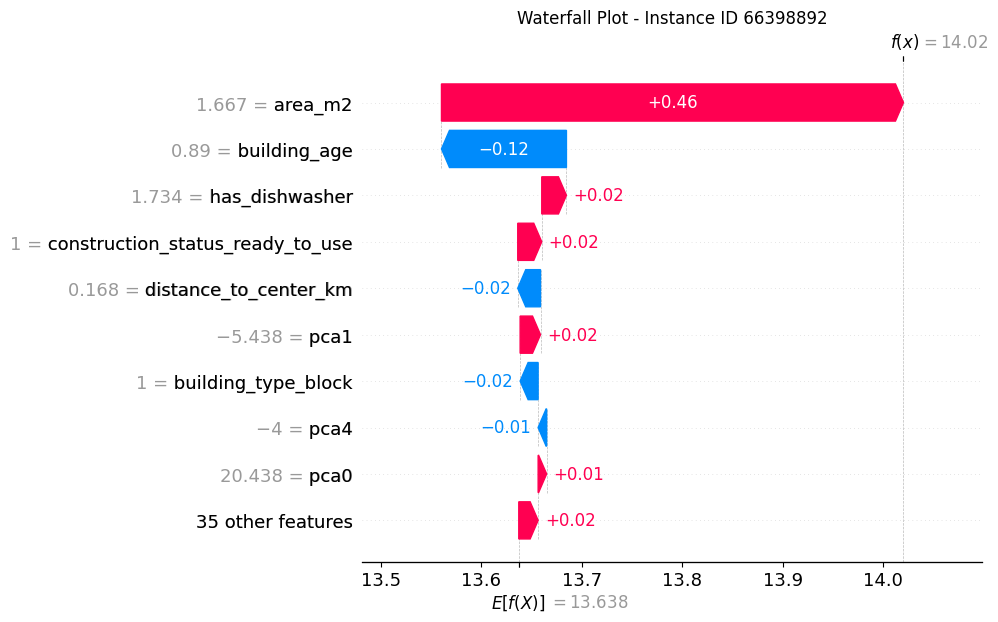

2025-06-03 13:27:04,522 - INFO - 
--- Analyzing instance ID: 65855498 (index in X_test_selected_final: 6057) ---
2025-06-03 13:27:04,522 - INFO - True Price: 1650000.00, Predicted Price: 853025.02, Residual: 796974.98


SHAP Force Plot for instance ID: 65855498

SHAP Waterfall Plot for instance ID: 65855498


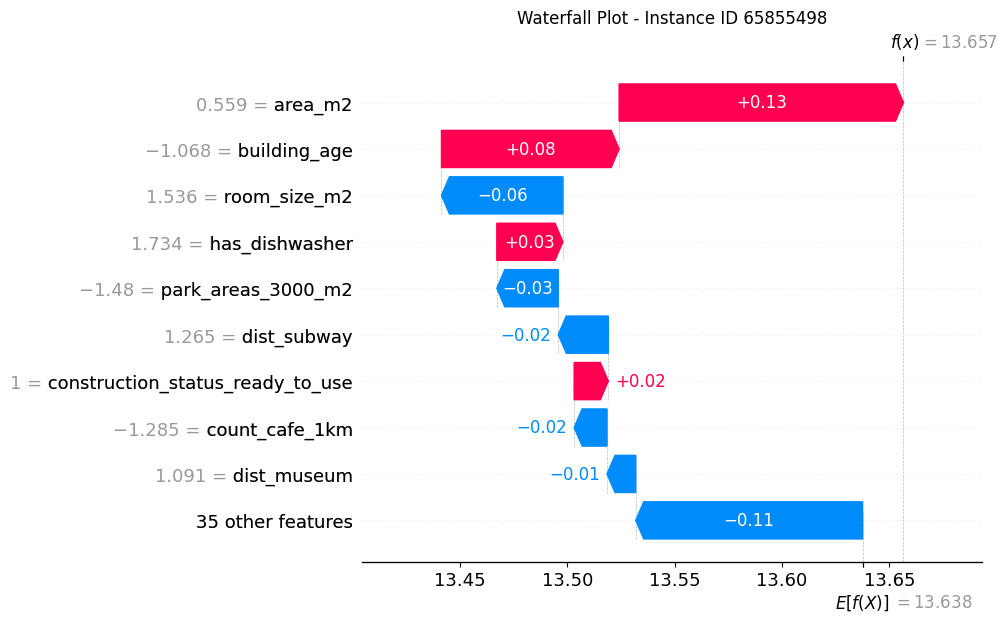

2025-06-03 13:27:04,633 - INFO - 
--- Analyzing instance ID: 65979830 (index in X_test_selected_final: 3526) ---
2025-06-03 13:27:04,633 - INFO - True Price: 2250000.00, Predicted Price: 1474890.28, Residual: 775109.72


SHAP Force Plot for instance ID: 65979830

SHAP Waterfall Plot for instance ID: 65979830


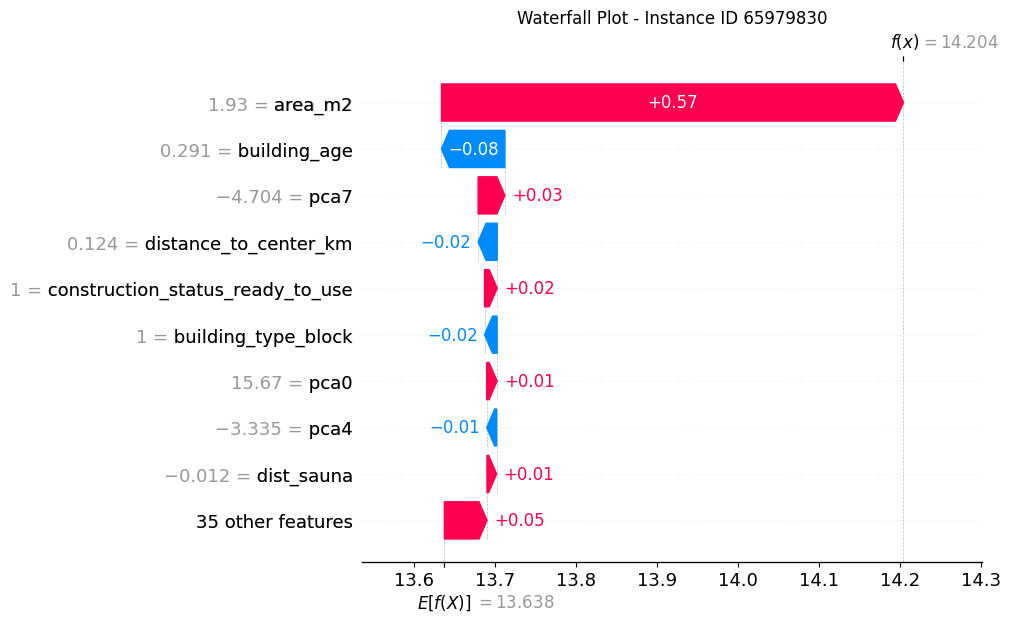

In [15]:
# Analyze top N high-residual instances
num_outliers_to_analyze = 3
top_outlier_indices = residuals_df.head(num_outliers_to_analyze).index

# Get the corresponding integer indices in X_test_selected_final (if its index is not default)
# SHAP values are typically aligned with the input data's row order.
# We assume X_test_selected_final and shap_values_test are row-aligned.
# If X_test_selected_final was sampled or re-indexed, careful mapping is needed.
# Here, we assume X_test_selected_final.index maps to the original test set indices.

shap_expected_value = explainer.expected_value
if isinstance(shap_expected_value, list): # For multi-output explainers
    shap_expected_value = shap_expected_value[0]


for instance_id in top_outlier_indices:
    try:
        instance_idx_in_shap_array = X_test_selected_final.index.get_loc(instance_id)
        logging.info(f"\n--- Analyzing instance ID: {instance_id} (index in X_test_selected_final: {instance_idx_in_shap_array}) ---")
        logging.info(f"True Price: {residuals_df.loc[instance_id, 'true_price']:.2f}, Predicted Price: {residuals_df.loc[instance_id, 'predicted_price']:.2f}, Residual: {residuals_df.loc[instance_id, 'residual']:.2f}")

        print(f"SHAP Force Plot for instance ID: {instance_id}")
        shap.force_plot(
            shap_expected_value,
            shap_values_test[instance_idx_in_shap_array, :],
            X_test_selected_final.iloc[instance_idx_in_shap_array, :],
            matplotlib=False # Use JS version for notebooks by default
        )
        # For matplotlib version (might need show=False and plt.show()):
        # shap.force_plot(explainer.expected_value, shap_values_test[instance_idx_in_shap_array,:], X_test_selected_final.iloc[instance_idx_in_shap_array,:], matplotlib=True, show=False)
        # plt.title(f"Force Plot - Instance ID {instance_id}")
        # plt.show()

        print(f"\nSHAP Waterfall Plot for instance ID: {instance_id}")
        # Create SHAP Explanation object for waterfall plot
        waterfall_explanation = shap.Explanation(
            values=shap_values_test[instance_idx_in_shap_array,:],
            base_values=shap_expected_value,
            data=X_test_selected_final.iloc[instance_idx_in_shap_array,:].values, # .values if data is df
            feature_names=X_test_selected_final.columns.tolist()
        )
        shap.waterfall_plot(waterfall_explanation, show=False) # max_display can be useful
        plt.title(f"Waterfall Plot - Instance ID {instance_id}")
        plt.show()

    except KeyError:
        logging.warning(f"Instance ID {instance_id} from residuals_df not found in X_test_selected_final.index. Skipping.")
    except Exception as e:
        logging.error(f"Error generating SHAP plots for instance ID {instance_id}: {e}")

--- 
## 7. Counterfactual Analysis (Conceptual Exploration)

Let's take one of the high-residual instances and see how changing its most influential features (according to SHAP) might alter the prediction. This is a manual approach.

**Note**: This is a simplified exploration. True counterfactual generation often requires optimization algorithms (e.g., finding the *minimal* change to achieve a target prediction) and specialized libraries like DiCE.

In [41]:
residuals_df


,true_price,predicted_price,residual,abs_residual
id,,,,
66398892,2040000.0000,1227242.5161,812757.4839,812757.4839
65855498,1650000.0000,853025.0175,796974.9825,796974.9825
65979830,2250000.0000,1474890.2773,775109.7227,775109.7227
965649852000,1890000.0000,1128538.4902,761461.5098,761461.5098
66313772,1800000.0000,1075941.1401,724058.8599,724058.8599
...,...,...,...,...
65877558,742377.0000,742397.9840,-20.9840,20.9840
66020861,593000.0000,593017.8968,-17.8968,17.8968
66389637,799000.0000,799016.5177,-16.5177,16.5177


In [56]:
import pandas as pd
import numpy as np
import logging

# --- Tailored Counterfactual Analysis ---

# Number of top outliers to analyze
N_INSTANCES_TO_ANALYZE = 20
# Number of top influential features to test for each instance
N_FEATURES_TO_TEST = 5

# Get the top N outliers from the residuals dataframe
try:
    # Ensure the column name for residuals is correct
    if 'abs_residual' in residuals_df.columns:
        top_outlier_indices = residuals_df.nlargest(N_INSTANCES_TO_ANALYZE, 'abs_residual').index
    else:
        # Fallback to the previous name if 'abs_residual' isn't found
        residuals_df['residual_abs'] = residuals_df['residual'].abs()
        top_outlier_indices = residuals_df.nlargest(N_INSTANCES_TO_ANALYZE, 'residual_abs').index
        logging.warning("Column 'abs_residual' not found. Used 'residual_abs' instead.")
except Exception as e:
    logging.error(f"Could not identify top outliers from residuals_df: {e}")
    # Create an empty dataframe to avoid crashing the notebook
    top_outlier_indices = pd.Index([])


# This list will hold the top 5 results from each instance
all_top_results = []

logging.info(f"--- Starting Tailored Counterfactual Analysis for Top {N_INSTANCES_TO_ANALYZE} Outliers ---")

# Loop through each of the top outlier instances
for instance_id in top_outlier_indices:
    try:
        instance_idx_in_shap = X_test_selected_final.index.get_loc(instance_id)
    except KeyError:
        logging.warning(f"Instance ID {instance_id} not found in the test set's SHAP values. Skipping.")
        continue

    original_features = X_test_selected_final.iloc[instance_idx_in_shap, :].copy()
    instance_shap_values = shap_values_test[instance_idx_in_shap, :]
    true_price = residuals_df.loc[instance_id, 'true_price']

    # Get the original prediction
    if 'sklearn_pipeline_model' in locals() and (MODEL_NAME_FOR_ANALYSIS not in ["LightGBM", "XGBoost", "XGBoostQuantile"] or not hasattr(actual_model, 'predict')):
        original_prediction_log = sklearn_pipeline_model.predict(original_features.to_frame().T)[0]
    else:
        original_prediction_log = actual_model.predict(original_features.to_frame().T)[0]
    original_prediction = np.exp(original_prediction_log)
    original_error = original_prediction - true_price

    feature_importances = pd.Series(np.abs(instance_shap_values), index=X_test_selected_final.columns)
    top_features = feature_importances.nlargest(N_FEATURES_TO_TEST).index.tolist()

    logging.info(f"Analyzing Instance ID: {instance_id} | Original Prediction: {original_prediction:,.0f} | True Price: {true_price:,.0f} | Error: {original_error:,.0f}")

    # Store results for this specific instance before finding the top 5
    instance_results = []

    for feature in top_features:
        original_value = original_features[feature]
        modification_points = {}

        # --- Define modification strategy based on feature type ---


        # 2. Handle boolean features (names or values are 0/1)
        is_boolean = (
            feature.startswith(('has_', 'construction_status_', 'building_type_')) or
            set(X_test_selected_final[feature].unique()) <= {0, 1}
        )
        if is_boolean:
            mod_value = 1 - original_value
            modification_points[f"flip_to_{int(mod_value)}"] = mod_value

        # 3. Handle numerical features for error simulation
        elif feature in ['area_m2', 'room_size_m2', 'floor_ratio'] or feature.startswith(('pca', 'distance_', 'dist_', 'count_')):
            modification_points = {
                "-25%": original_value * 0.75,
                "-10%": original_value * 0.90,
                "*-1": original_value * -1,
                "+10%": original_value * 1.10,
                "+25%": original_value * 1.25,
            }
        elif feature in ['building_age',]:
            modification_points = {
                "-25%": original_value * 0.75,
                "-50%": original_value * 0.50,
                "*-1": original_value * -1,
                "+50%": original_value * 1.50,
                "+25%": original_value * 1.25,
            }
                # 1. Skip 'pano_' features
        elif feature.startswith('pano_'):
            modification_points = {
                "-50%": original_value * 0.50,
                "*-1": original_value * -1,
                "+50%": original_value * 1.50,
            }
            # logging.info(f"  - Skipping district-level feature '{feature}'")
            continue
        else:
            # logging.warning(f"  - Skipping feature '{feature}' as it has no defined modification strategy.")
            continue

        # --- Apply modifications and calculate impact ---
        for mod_name, mod_value in modification_points.items():
            if np.isclose(mod_value, original_value):
                continue

            counterfactual_features = original_features.copy()
            counterfactual_features[feature] = mod_value

            if 'sklearn_pipeline_model' in locals() and (MODEL_NAME_FOR_ANALYSIS not in ["LightGBM", "XGBoost", "XGBoostQuantile"] or not hasattr(actual_model, 'predict')):
                cf_prediction_log = sklearn_pipeline_model.predict(counterfactual_features.to_frame().T)[0]
            else:
                cf_prediction_log = actual_model.predict(counterfactual_features.to_frame().T)[0]
            
            cf_prediction = np.exp(cf_prediction_log)
            new_error = cf_prediction - true_price
            error_reduction = abs(original_error) - abs(new_error)
            
            if error_reduction>5000:
                instance_results.append({
                    "instance_id": instance_id,
                    "feature": feature,
                    "modification": mod_name,
                    "original_prediction": original_prediction,
                    "cf_prediction": cf_prediction,
                    "true_price": true_price,
                    "error_reduction": error_reduction
                })
    
    # After checking all features for an instance, get the top 5 and append
    if instance_results:
        instance_df = pd.DataFrame(instance_results)
        top_5_for_instance = instance_df.nlargest(5, 'error_reduction')
        all_top_results.append(top_5_for_instance)


# --- Analyze and Display Final Results ---
if all_top_results:
    final_results_df = pd.concat(all_top_results)

    pd.set_option('display.max_rows', 100)
    pd.set_option('display.float_format', '{:,.2f}'.format)

    print("\n--- Counterfactual Analysis Summary ---")
    print("Top 5 changes per instance that reduced prediction error the most:")
    
    # Set index for better readability
    final_results_df.set_index('instance_id', inplace=True)
    display(final_results_df)

else:
    logging.warning("No counterfactual results were generated.")

2025-06-03 17:17:44,211 - INFO - --- Starting Tailored Counterfactual Analysis for Top 20 Outliers ---
2025-06-03 17:17:44,310 - INFO - Analyzing Instance ID: 66398892 | Original Prediction: 1,227,243 | True Price: 2,040,000 | Error: -812,757
2025-06-03 17:17:44,354 - INFO - Analyzing Instance ID: 65855498 | Original Prediction: 853,025 | True Price: 1,650,000 | Error: -796,975
2025-06-03 17:17:44,366 - INFO - Analyzing Instance ID: 65979830 | Original Prediction: 1,474,890 | True Price: 2,250,000 | Error: -775,110
2025-06-03 17:17:44,383 - INFO - Analyzing Instance ID: 965649852000 | Original Prediction: 1,128,538 | True Price: 1,890,000 | Error: -761,462
2025-06-03 17:17:44,395 - INFO - Analyzing Instance ID: 66313772 | Original Prediction: 1,075,941 | True Price: 1,800,000 | Error: -724,059
2025-06-03 17:17:44,410 - INFO - Analyzing Instance ID: 65302252 | Original Prediction: 1,654,730 | True Price: 2,372,000 | Error: -717,270
2025-06-03 17:17:44,422 - INFO - Analyzing Instance ID:


--- Counterfactual Analysis Summary ---
Top 5 changes per instance that reduced prediction error the most:


,feature,modification,original_prediction,cf_prediction,true_price,error_reduction
instance_id,,,,,,
66398892,building_age,*-1,"1,227,242.52","1,699,307.55","2,040,000.00","472,065.03"
66398892,area_m2,+25%,"1,227,242.52","1,498,090.66","2,040,000.00","270,848.15"
66398892,area_m2,+10%,"1,227,242.52","1,362,587.79","2,040,000.00","135,345.28"
66398892,distance_to_center_km,*-1,"1,227,242.52","1,285,138.23","2,040,000.00","57,895.71"
66398892,building_age,+50%,"1,227,242.52","1,246,351.31","2,040,000.00","19,108.79"
65855498,room_size_m2,*-1,"853,025.02","1,044,854.64","1,650,000.00","191,829.62"
65855498,area_m2,+25%,"853,025.02","935,758.54","1,650,000.00","82,733.52"
65855498,room_size_m2,-25%,"853,025.02","918,633.18","1,650,000.00","65,608.16"
65855498,area_m2,+10%,"853,025.02","901,741.78","1,650,000.00","48,716.76"


--- 
## 8. Hyperparameter Quality Analysis (Using Optuna Visualizations)

This section uses Optuna's visualization tools to inspect the hyperparameter tuning process for the analyzed model. The study data is loaded from the `tuning.db` SQLite file generated by `train.py`.

In [24]:
optuna_dir = config_values.get("optuna_dir", "optuna_studies")
db_file = "tuning.db"
STUDY_DB_PATH = f"sqlite:///{os.path.join("..", optuna_dir, db_file)}"

print(STUDY_DB_PATH)
# The study name format from train.py: f"{model_name}_{SELECTED_FEATURES_FILENAME}_study"
optuna_study_name = f"{MODEL_NAME_FOR_ANALYSIS}_{SELECTED_FEATURES_FILENAME_FOR_ANALYSIS}_study"

logging.info(f"Loading Optuna study: '{optuna_study_name}' from storage: '{STUDY_DB_PATH}'")


loaded_study = optuna.load_study(study_name=optuna_study_name, storage=STUDY_DB_PATH)
logging.info(f"Successfully loaded study '{optuna_study_name}' with {len(loaded_study.trials)} trials.")
logging.info(f"Best value ({loaded_study.direction.name} for {loaded_study.best_trial.user_attrs.get('MLFLOW_CALLBACK_METRIC_NAME', 'objective value')}): {loaded_study.best_value:.6f}")
logging.info(f"Best hyperparameters: {loaded_study.best_params}")


2025-06-03 13:29:02,037 - INFO - Loading Optuna study: 'LightGBM_rfecv_all_nfeat_44_pca_scaled_count_study' from storage: 'sqlite:///../optuna_studies/tuning.db'


sqlite:///../optuna_studies/tuning.db


2025-06-03 13:29:02,488 - INFO - Successfully loaded study 'LightGBM_rfecv_all_nfeat_44_pca_scaled_count_study' with 501 trials.
2025-06-03 13:29:02,498 - INFO - Best value (MINIMIZE for objective value): 0.059090
2025-06-03 13:29:02,501 - INFO - Best hyperparameters: {'model__learning_rate': 0.07725697519553701, 'model__n_estimators': 1500, 'model__num_leaves': 97, 'model__max_depth': 28, 'model__min_child_samples': 11, 'model__subsample': 0.7732597144089367, 'model__colsample_bytree': 0.8903726842049561, 'model__reg_alpha': 0.015833982849066317, 'model__reg_lambda': 0.03814882063749428}


### Optuna Optimization History

In [25]:
if loaded_study:
    try:
        fig_hist = optuna.visualization.plot_optimization_history(loaded_study)
        fig_hist.update_layout(title_text=f"Optimization History - {MODEL_NAME_FOR_ANALYSIS} ({SELECTED_FEATURES_FILENAME_FOR_ANALYSIS})", title_x=0.5)
        fig_hist.show()
    except Exception as e:
        logging.error(f"Could not plot optimization history: {e}")
else:
    logging.warning("Optuna study not loaded. Skipping optimization history plot.")

### Hyperparameter Importances

In [28]:
import logging


logging.getLogger('optuna').setLevel(logging.ERROR)

if loaded_study:
    try:
        fig_importance = optuna.visualization.plot_param_importances(loaded_study)
        fig_importance.update_layout(title_text=f"Hyperparameter Importances - {MODEL_NAME_FOR_ANALYSIS} ({SELECTED_FEATURES_FILENAME_FOR_ANALYSIS})", title_x=0.5)
        fig_importance.show()
    except Exception as e:
        logging.error(f"Could not plot hyperparameter importances: {e}")
else:
    logging.warning("Optuna study not loaded. Skipping hyperparameter importance plot.")

### Parallel Coordinate Plot
Helps visualize relationships between parameters and objective value.

In [29]:
if loaded_study:
    try:
        fig_parallel = optuna.visualization.plot_parallel_coordinate(loaded_study)
        fig_parallel.update_layout(title_text=f"Parallel Coordinate Plot - {MODEL_NAME_FOR_ANALYSIS} ({SELECTED_FEATURES_FILENAME_FOR_ANALYSIS})", title_x=0.5)
        fig_parallel.show()
    except Exception as e:
        logging.error(f"Could not plot parallel coordinate plot: {e}")
else:
    logging.warning("Optuna study not loaded. Skipping parallel coordinate plot.")

### Slice Plot
Shows how individual hyperparameters affect the objective value.

In [30]:
if loaded_study:
    try:
        # You might want to select specific params if there are too many
        # params_to_slice = [p for p in loaded_study.best_params.keys() if loaded_study.trials_dataframe()[f"params_{p}"].nunique() > 1][:5] # Example: top 5 varying params
        
        # If no specific params, Optuna will try to plot all, which might be too many
        # For now, let Optuna decide or specify a few key ones based on importance plot
        fig_slice = optuna.visualization.plot_slice(loaded_study) # params=params_to_slice if defined
        fig_slice.update_layout(title_text=f"Slice Plot - {MODEL_NAME_FOR_ANALYSIS} ({SELECTED_FEATURES_FILENAME_FOR_ANALYSIS})", title_x=0.5)
        fig_slice.show()
    except Exception as e:
        logging.error(f"Could not plot slice plot: {e}")
else:
    logging.warning("Optuna study not loaded. Skipping slice plot.")

--- 
## 9. Conclusion

This notebook provided tools for:
- Understanding feature contributions using SHAP.
- Identifying and analyzing outliers or instances with high prediction errors.
- Conceptually exploring counterfactuals by manually changing feature values.
- Visualizing hyperparameter tuning results from Optuna studies.

Further analysis could involve:
- More systematic counterfactual generation.
- Deeper dives into specific feature interactions using SHAP.
- Comparing SHAP results across different models.
---